# Walkthrough - RBIG

In [1]:
import sys
sys.path.append("../")

# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.information.reduction import information_reduction
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob
from rbig_jax.transforms.gaussian import init_params
from rbig_jax.transforms.rbig import rbig_init

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

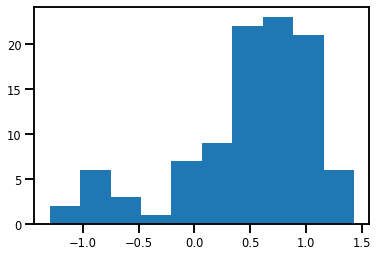

In [2]:
# get data
data = get_classic(100)

# plot data
plt.hist(data[:, 1], 10);

## Logging

In [3]:
wandb.init(project="rbigjax-demo-2d", entity="emanjohnson91")


W&B Run: https://app.wandb.ai/emanjohnson91/rbigjax-demo-2d/runs/3sedng4j

In [4]:

# config parameters
wandb.config.n_samples = 10_000
wandb.config.dataset = "classic"
wandb.config.method = "histogram"
wandb.config.support_extension = 10
wandb.config.precision = 50
wandb.config.alpha = 0.0
wandb.config.n_layers = 20

wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Data

In [5]:
def plot_joint(data, color: str = "red", title: str = "", kind="kde", logger=None):

    plt.figure()
    sns.jointplot(x=data[:, 0], y=data[:, 1], kind=kind, color=color)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    

def plot_joint_prob(data, probs, cmap="Reds", title="", logger=None):

    fig, ax = plt.subplots()
    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap=cmap)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(h,)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

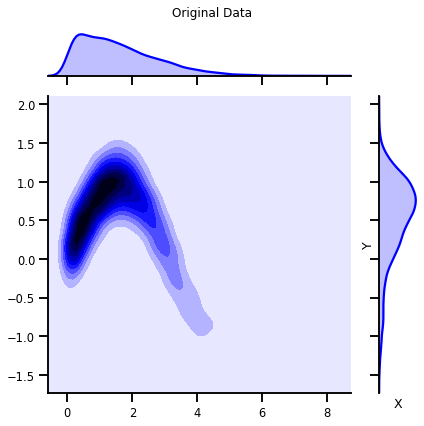

In [6]:
# %%wandb
# get data
data = get_classic(10_000)

# plot data
plot_joint(data, "blue", "Original Data", logger=False)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

<AxesSubplot:>

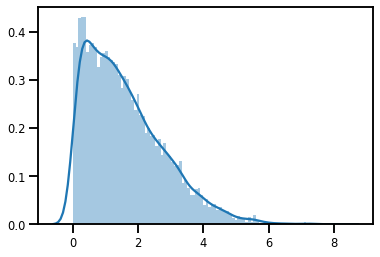

In [7]:
X_marg = data[:, 0]

sns.distplot(X_marg, bins=100)

## Histogram Uniformization

In [29]:
from rbig_jax.transforms.histogram import (
    get_hist_params
)
from rbig_jax.transforms.kde import get_kde_params
from rbig_jax.transforms.uniformize import forward_uniformization, inverse_uniformization, forward_uniformization_gradient

In [102]:
X_u, X_ldj, hist_params = get_hist_params(X_marg, support_extension=10, precision=1000, alpha=1e-5) 



<AxesSubplot:>

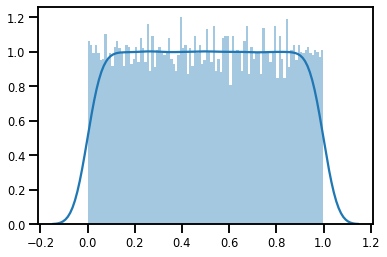

In [103]:
sns.distplot(X_u, bins=100)

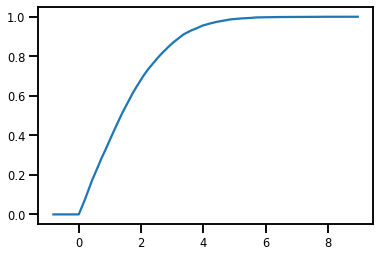

In [104]:
plt.plot(hist_params.support, hist_params.quantiles)

### Forward Transformation

<AxesSubplot:>

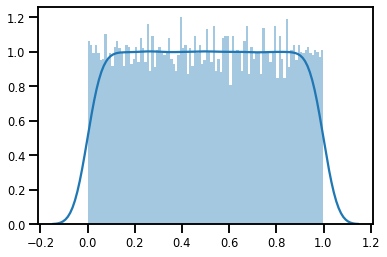

In [27]:
X_u = forward_uniformization(X_marg, hist_params)

sns.distplot(X_u, bins=100)

### Inverse Transformation

<AxesSubplot:>

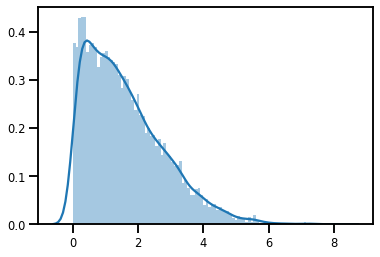

In [28]:
X_approx = inverse_uniformization(X_u, hist_params)


sns.distplot(X_approx, bins=100)

### Jacobian

<AxesSubplot:>

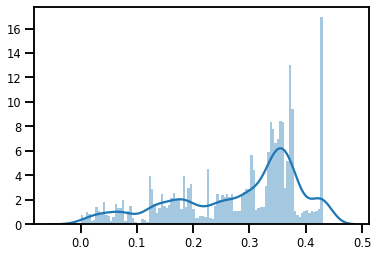

In [30]:
X_grad = forward_uniformization_gradient(X_marg, hist_params)


sns.distplot(X_grad, bins=100)

## Inverse CDF Estimation

In [56]:
from rbig_jax.transforms.inversecdf import invgauss_forward_transform, invgauss_inverse_transform

### Forward Transform

<AxesSubplot:>

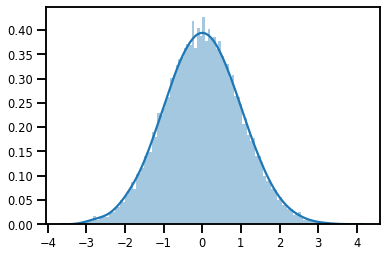

In [57]:
X_g = invgauss_forward_transform(X_u)

sns.distplot(X_g, bins=100)

In [ ]:
chex.asse

### Inverse Transform

<AxesSubplot:>

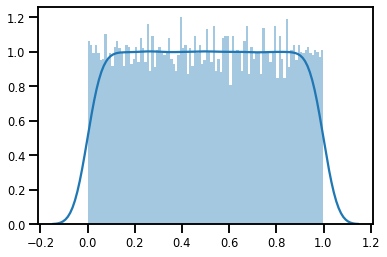

In [58]:
X_u = invgauss_inverse_transform(X_g)

sns.distplot(X_u, bins=100)

## Univariate Gaussianization

In [124]:
from rbig_jax.transforms.gaussianize import (
    forward_gaussianize_transform, 
    inverse_gaussianize_transform, 
    inverse_gaussianize_transform_constrained,
    get_gauss_params_hist
)

<AxesSubplot:>

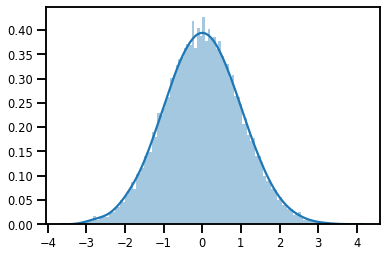

In [125]:
X_g, gauss_params = get_gauss_params_hist(X_marg, support_extension=10, precision=1_000)

sns.distplot(X_g, bins=100)

-3.1608146761933904 3.7141918299308925


<AxesSubplot:>

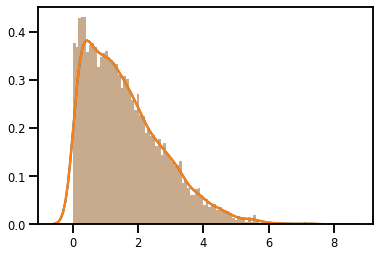

In [133]:
X_approx = inverse_gaussianize_transform(X_g, gauss_params)

sns.distplot(X_approx, bins=100)
sns.distplot(X_marg, bins=100)

-3.708419121159862 3.7141918299308925


<AxesSubplot:>

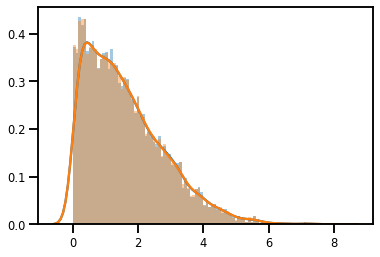

In [134]:
X_approx = inverse_gaussianize_transform_constrained(X_g, gauss_params, get_gauss_params_hist)

sns.distplot(X_approx, bins=100)
sns.distplot(X_marg, bins=100)

### KDE

In [62]:
X_u, X_ldj, kde_params = get_kde_params(X_marg, support_extension=10, precision=1000) 

In [ ]:
X_g = invgauss_forward_transform(X_u)

sns.distplot(X_g, bins=100)

## 2D Data

In [226]:
from rbig_jax.transforms.gaussianize import (
    get_gauss_params_hist, 
    forward_gaussianize_transform, 
    inverse_gaussianize_transform
)
from rbig_jax.transforms.marginal import get_params_marginal, marginal_transform

### Parameter Fitting

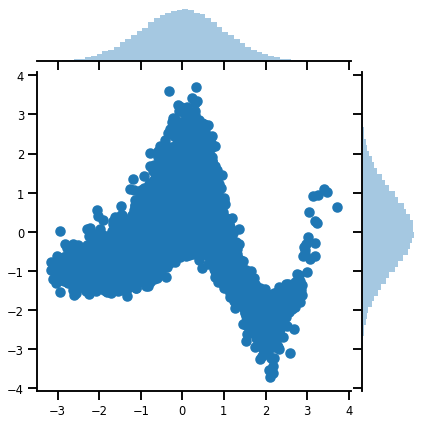

In [258]:
get_params_f = partial(get_gauss_params_hist, support_extension=10, precision=1000, alpha=1e-5)

X_g, params = get_params_marginal(data, get_params_f)

sns.jointplot(X_g[:, 0], X_g[:, 1])

### Forward Transformation

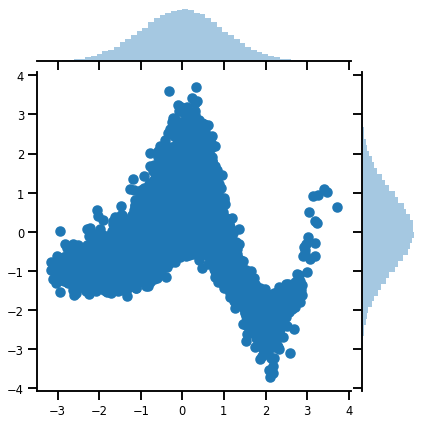

In [228]:
X_g = marginal_transform(data, forward_gaussianize_transform, params)

sns.jointplot(X_g[:, 0], X_g[:, 1])

### Inverse Transformation

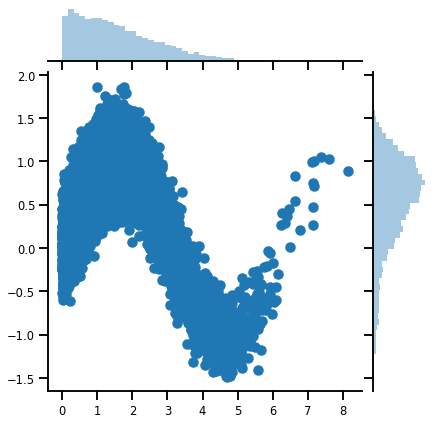

In [229]:
X_approx = marginal_transform(X_g, inverse_gaussianization, params)

sns.jointplot(X_approx[:, 0], X_approx[:, 1])

#### Speed

In [240]:
%%time
test_data = np.array(onp.random.randn(100_000, 50))

get_params_f_jitted = jax.jit(partial(get_hist_params, support_extension=10, precision=1000, alpha=1e-5))

_ = get_params_f_jitted(data[:10])

CPU times: user 2.87 s, sys: 17.8 ms, total: 2.89 s
Wall time: 2.87 s


In [241]:
%timeit get_params_f_jitted(data)
%timeit get_params_f_jitted(test_data)

318 µs ± 23.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
164 µs ± 29.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [242]:
%%time

get_gauss_params_f_jitted = jax.jit(partial(get_gauss_params_hist, support_extension=10, precision=1000, alpha=1e-5))

X_mg_jitted = get_gauss_params_f_jitted(data[:10])

CPU times: user 17.5 s, sys: 438 ms, total: 17.9 s
Wall time: 7.12 s


In [239]:
%timeit get_gauss_params_f_jitted(data)
%timeit get_gauss_params_f_jitted(test_data)

313 µs ± 26 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 4.01 times longer than the fastest. This could mean that an intermediate result is being cached.
224 µs ± 142 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Rotation

In [244]:
from rbig_jax.transforms.rotation import get_pca_params, rot_forward_transform, rot_inverse_transform

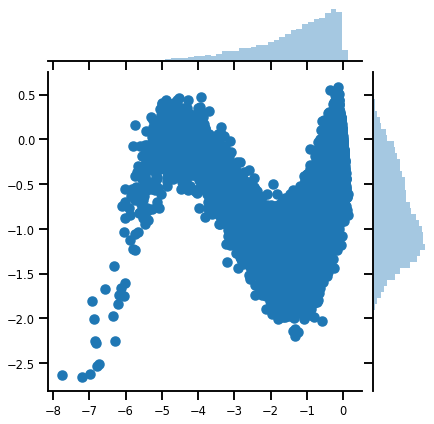

In [249]:
X_r, rot_params = get_pca_params(data)

sns.jointplot(X_r[:, 0], X_r[:, 1])

#### After Marginal Gaussianization

In [261]:
%%time

# Marginal Gaussianization
get_params_f = partial(get_gauss_params_hist, support_extension=10, precision=1000, alpha=1e-5)
X_mg, params = get_params_marginal(data, get_params_f)

# PCA Rotation
X_r, rot_params = get_pca_params(X_mg)

CPU times: user 299 ms, sys: 22.8 ms, total: 322 ms
Wall time: 238 ms


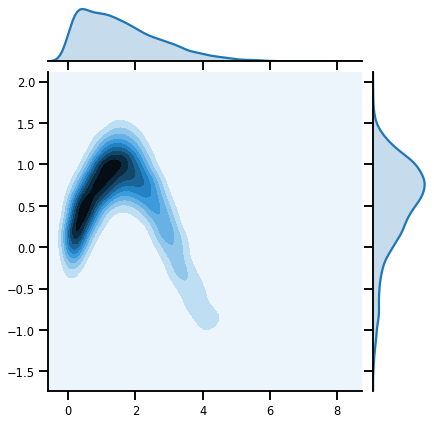

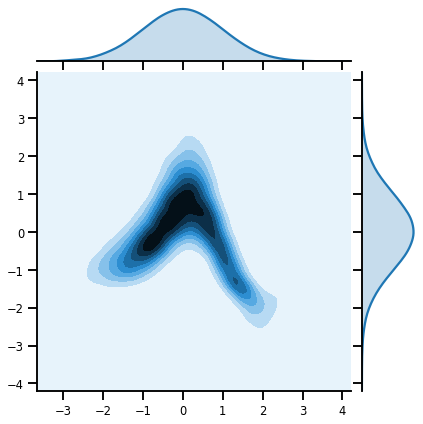

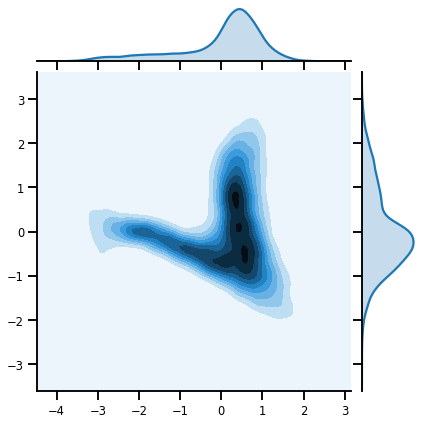

In [262]:
sns.jointplot(data[:, 0], data[:, 1], kind='kde')

sns.jointplot(X_mg[:, 0], X_mg[:, 1], kind='kde')


sns.jointplot(X_r[:, 0], X_r[:, 1], kind='kde')

#### Speed

In [288]:
%%time 

X_r, rot_params = get_pca_params(X_mg.block_until_ready())

CPU times: user 5.85 ms, sys: 8.89 ms, total: 14.7 ms
Wall time: 2.95 ms


In [289]:
%timeit get_pca_params(X_mg.block_until_ready())
%timeit get_pca_params(test_data.block_until_ready())

2.81 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
123 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [291]:
%%time

get_pca_params_jitted = jax.jit(get_pca_params)

X_r, rot_params = get_pca_params_jitted(np.array(X_mg).block_until_ready())

CPU times: user 986 µs, sys: 0 ns, total: 986 µs
Wall time: 1.22 ms


In [293]:
%timeit get_pca_params_jitted(np.array(X_mg).block_until_ready())
%timeit get_pca_params_jitted(test_data.block_until_ready())

466 µs ± 68.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
109 ms ± 2.98 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## RBIG Block

In [319]:
from rbig_jax.transforms.block import (
    init_gauss_hist_block, 
    forward_gauss_block_transform,
    inverse_gauss_block_transform)

In [320]:
# initialize transformation
init_rbig_transform = init_gauss_hist_block()

# forward transformation
X_g, params = init_rbig_transform(np.array(data))

In [323]:
params.rotation.shape, params.support.shape

((2, 2), (2, 1000))

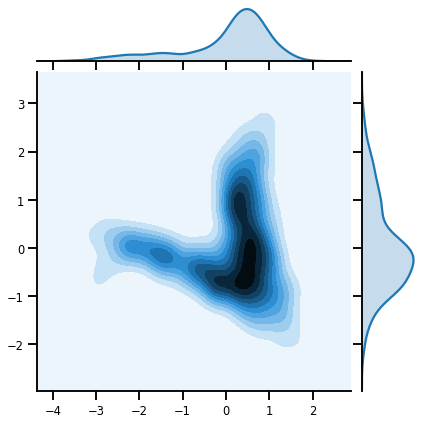

In [314]:
# plot
sns.jointplot(X_g[:1_000, 0], X_g[:1_000, 1], kind='kde')

### Frward Transformation

In [330]:
X_g_f = forward_gauss_block_transform(np.array(data), params)

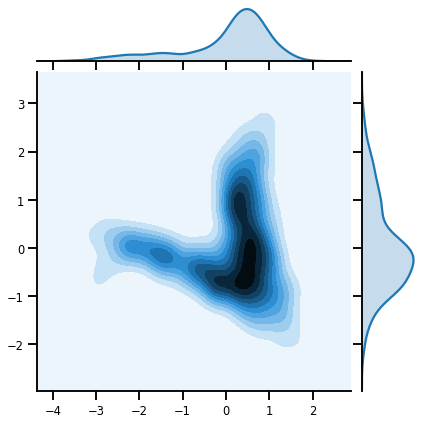

In [331]:
sns.jointplot(X_g_f[:1_000, 0], X_g_f[:1_000, 1], kind='kde')

### Inverse Transform

In [334]:
X_approx = inverse_gauss_block_transform(X_g_f, params)

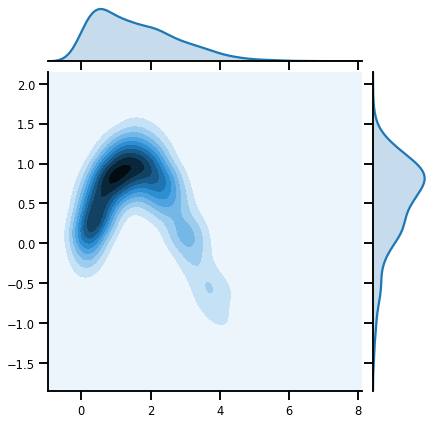

In [335]:
sns.jointplot(X_approx[:1_000, 0], X_approx[:1_000, 1], kind='kde')

#### Speed

In [337]:
%%time

# initialize transformation
init_rbig_transform = init_gauss_hist_block()

# forward transformation
X_g, params = init_rbig_transform(np.array(data))

CPU times: user 335 ms, sys: 46.8 ms, total: 382 ms
Wall time: 309 ms


In [338]:
%timeit init_rbig_transform(np.array(data).block_until_ready())

302 ms ± 5.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [339]:
%%time


# initialize transformation
init_rbig_transform_jitted = jax.jit(init_gauss_hist_block())

# forward transformation
X_g, params = init_rbig_transform_jitted(np.array(data))

CPU times: user 6.05 s, sys: 15.4 ms, total: 6.06 s
Wall time: 6.05 s


In [340]:
%timeit init_rbig_transform_jitted(np.array(data).block_until_ready())

8.31 ms ± 535 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Gaussianization

In [411]:
!pip install --upgrade objax

     |████████████████████████████████| 6.8 MB 6.5 kB/s eta 0:00:01
  Using cached google_auth_oauthlib-0.4.1-py2.py3-none-any.whl (18 kB)
     |████████████████████████████████| 3.8 MB 17.6 MB/s eta 0:00:01
     |████████████████████████████████| 779 kB 35.9 MB/s eta 0:00:0101
     |████████████████████████████████| 114 kB 39.3 MB/s eta 0:00:01
  Using cached Werkzeug-1.0.1-py2.py3-none-any.whl (298 kB)
     |████████████████████████████████| 94 kB 98 kB/s s eta 0:00:01
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
     |████████████████████████████████| 47 kB 6.1 MB/s  eta 0:00:01
  Using cached oauthlib-3.1.0-py2.py3-none-any.whl (147 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Created wheel for objax: filename=objax-1.1.0-py3-none-any.whl size=61798 sha256=34aec6ae88353c837a41e8b95735c3b7e69d889d9fddfcb4066b44d296f66bd9
  Stored in directory: /home/emmanuel/.cache/pip/wheels/f

In [479]:
import objax

class RBIGHistBlock(objax.Module):
    def __init__(self, support_extension=10, alpha=1e-5, precision=1_000):
        self.support_extension = objax.StateVar(support_extension)
        self.alpha = objax.StateVar(alpha)
        self.precision = objax.StateVar(precision)
        self.block_transform = init_gauss_hist_block_params()
        
    def __call__(self, X):
        return self.block_transform(X)
    
    def transform(self, X):
        pass
    
    def inverse_transform(self, X):
        pass
    
    def sample(self, X):
        pass
        
class RBIG(objax.Module):
    def __init__(
        self, 
        support_extension=10, 
        alpha=1e-5, 
        precision=1_000,
        n_layers=100
    ):
        self.support_extension = objax.StateVar(support_extension)
        self.alpha = objax.StateVar(alpha)
        self.precision = objax.StateVar(precision)
        self.block_transform = init_gauss_hist_block_params()
        self.n_layers = objax.StateVar(n_layers)
        
    def __call__(self, X):
        
        params = []
        
        for ilayer in tqdm.trange(self.n_layers.value):
            X, block_params = self.block_transform(X)

            params.append(block_params)
        self.params = objax.ModuleList(params)
        return X
    
    def transform(self, X):
        for iparams in tqdm.tqdm(self.params):
            X = forward_gauss_block_transform(X, iparams)
        return X
    def inverse_transform(self, X):
        for iparams in tqdm.tqdm(self.params[::-1]):
            X = inverse_gauss_block_transform(X, iparams)
        return X
    
    def sample(self, X):
        pass
        
class RBIGFlow(objax.Module):
    def __init__(
        self, 
        rbig_block,
        n_layers: int=26
    ):
        self.block_transform = rbig_block
        self.n_layers = objax.StateVar(n_layers)
        
    def __call__(self, X):
        
        params = []
        
        for ilayer in tqdm.trange(self.n_layers.value):
            X, block_params = self.block_transform(X)

            params.append(block_params)
        self.params = objax.ModuleList(params)
        return X
    
    def transform(self, X):
        for iparams in tqdm.tqdm(self.params):
            X = forward_gauss_block_transform(X, iparams)
        return X
    def inverse_transform(self, X):
        for iparams in tqdm.tqdm(self.params[::-1]):
            X = inverse_gauss_block_transform(X, iparams)
        return X
    
    def sample(self, X):
        pass
        

In [487]:
rbig_block = jax.jit(init_gauss_hist_block_params())

rbig_flow = RBIGFlow(rbig_block=rbig_block, n_layers=1_000)

X_trans = rbig_flow(np.array(data))

100%|██████████| 1000/1000 [00:14<00:00, 71.26it/s]


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


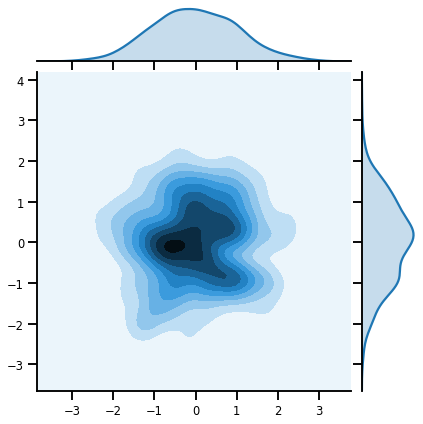

In [489]:
rbig_block = RBIGHistBlock()

rbig_flow = RBIGFlow(rbig_block=rbig_block, n_layers=10)

X_trans = rbig_flow(np.array(data))

# plot results
sns.jointplot(X_trans[:1_000, 0], X_trans[:1_000, 1], kind='kde')

100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


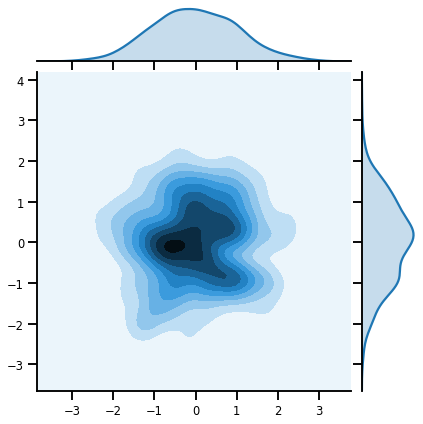

In [490]:
X_trans = rbig_flow.transform(np.array(data))

# plot results
sns.jointplot(X_trans[:1_000, 0], X_trans[:1_000, 1], kind='kde')

In [ ]:
rbig_flow = RBIG(n_layers=26)

X_trans = rbig_flow(np.array(data))

In [471]:
rbig_flow = objax.Jit(rbig_flow)

X_trans = rbig_flow(np.array(data))

TypeError: 'JaxprTracer' object cannot be interpreted as an integer

100%|██████████| 26/26 [00:08<00:00,  3.18it/s]


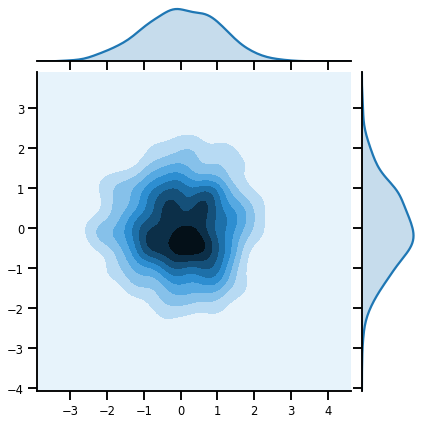

In [466]:
sns.jointplot(X_trans[:1_000, 0], X_trans[:1_000, 1], kind='kde')

In [467]:
X_trans = rbig_flow.transform(np.array(data))

100%|██████████| 26/26 [00:03<00:00,  8.04it/s]


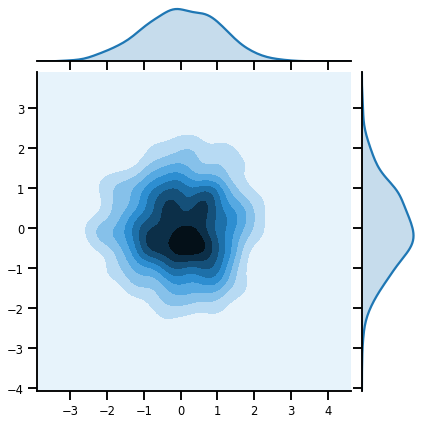

In [468]:
sns.jointplot(X_trans[:1_000, 0], X_trans[:1_000, 1], kind='kde')

In [469]:
X_approx = rbig_flow.inverse_transform(X_trans)

100%|██████████| 26/26 [00:01<00:00, 22.71it/s]


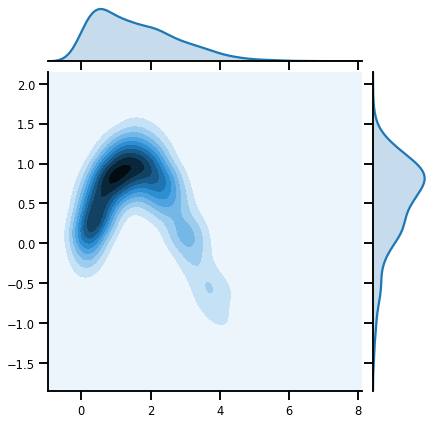

In [461]:
sns.jointplot(X_approx[:1_000, 0], X_approx[:1_000, 1], kind='kde')

In [ ]:
X_trans

In [424]:
%%time



X = rbig_block.fit_transform(np.array(data))

CPU times: user 253 ms, sys: 50.7 ms, total: 304 ms
Wall time: 240 ms


In [427]:
rbig_block_jitted

In [443]:
n_layers = 100

# initialize transformation
rbig_block = RBIGHistBlock()


X_trans = np.array(data)

for ilayer in tqdm.trange(n_layers):
    X_trans = rbig_block(X_trans)
    
    layer_params.append(rbig_block_jitted)

100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


In [444]:
n_layers = 100

# initialize transformation
rbig_block = RBIGHistBlock()

rbig_block_jitted = objax.Jit(rbig_block)


X_trans = np.array(data)

for ilayer in tqdm.trange(n_layers):
    X_trans = rbig_block_jitted(X_trans)
    
    layer_params.append(rbig_block_jitted)

100%|██████████| 100/100 [00:12<00:00,  8.01it/s]


In [435]:
%timeit rbig_block_jitted(np.array(data))

9.89 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [422]:
rbig_block.vars()

{'(RBIGHistBlock).support_extension': <objax.variable.StateVar at 0x7fdc78666100>,
 '(RBIGHistBlock).alpha': <objax.variable.StateVar at 0x7fdc786661f0>,
 '(RBIGHistBlock).precision': <objax.variable.StateVar at 0x7fdc78666520>,
 '(RBIGHistBlock).params': <objax.variable.StateVar at 0x7fdc79a352e0>}

In [361]:
from rbig_jax.transforms.block import (
    init_gauss_hist_block, 
    init_gauss_hist_block_params,
    forward_gauss_block_transform,
    inverse_gauss_block_transform)

In [440]:
n_layers = 100
layer_params = []

X_trans = np.array(data)

# initialize transformation
init_rbig_transform = init_gauss_hist_block_params()

for ilayer in tqdm.trange(n_layers):
    X_trans, params = init_rbig_transform(X_trans)
    
    layer_params.append(params)

100%|██████████| 26/26 [00:07<00:00,  3.32it/s]


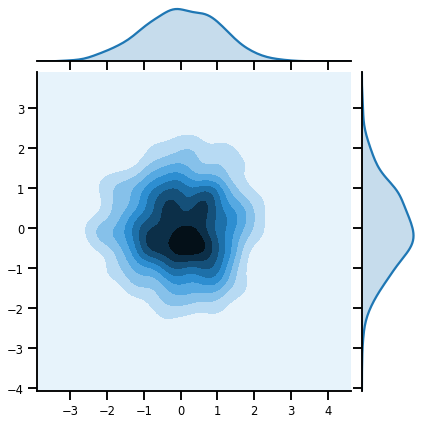

In [371]:
sns.jointplot(X_trans[:1_000, 0], X_trans[:1_000, 1], kind='kde')

### Forward Transformation

In [372]:
X_trans = np.array(data)

for iparams in tqdm.tqdm(layer_params):
    X_trans = forward_gauss_block_transform(X_trans, iparams)


100%|██████████| 26/26 [00:03<00:00,  8.10it/s]


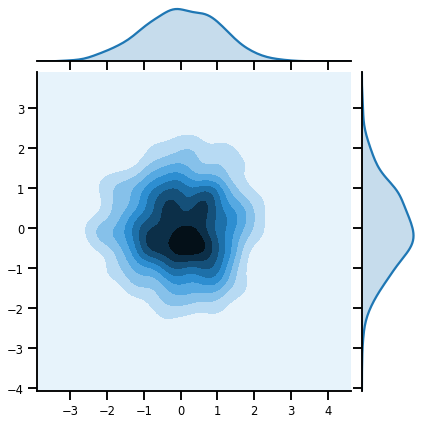

In [373]:
sns.jointplot(X_trans[:1_000, 0], X_trans[:1_000, 1], kind='kde')

### Inverse Transformation

In [376]:
X_approx = X_trans.copy()

for iparams in tqdm.tqdm(layer_params[::-1]):
    X_approx = inverse_gauss_block_transform(X_approx, iparams)

100%|██████████| 26/26 [00:01<00:00, 19.90it/s]


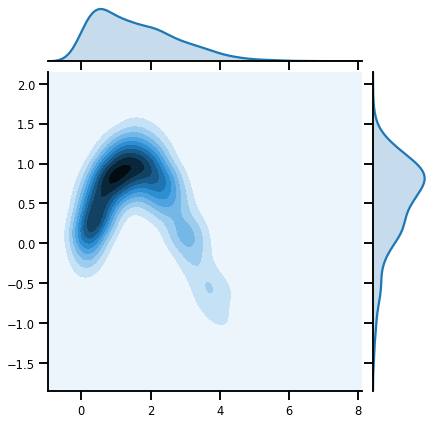

In [377]:
sns.jointplot(X_approx[:1_000, 0], X_approx[:1_000, 1], kind='kde')

### Speed

In [441]:
X_trans = np.array(data)

forward_f_jitted = jax.jit(forward_gauss_block_transform)

for iparams in tqdm.tqdm(layer_params):
    X_trans = forward_f_jitted(X_trans, iparams)

100%|██████████| 26/26 [00:00<00:00, 908.33it/s]


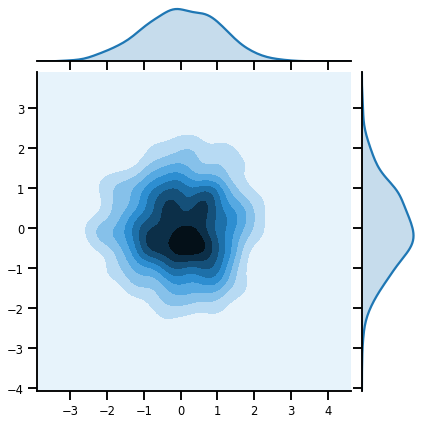

In [391]:
sns.jointplot(X_trans[:1_000, 0], X_trans[:1_000, 1], kind='kde')

In [392]:
X_approx = X_trans.copy()

inverse_f_jitted = jax.jit(inverse_gauss_block_transform)

for iparams in tqdm.tqdm(layer_params[::-1]):
    X_approx = inverse_f_jitted(X_approx, iparams)

100%|██████████| 26/26 [00:00<00:00, 622.17it/s]


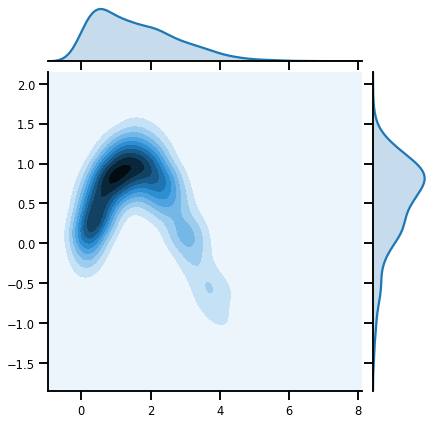

In [393]:
sns.jointplot(X_approx[:1_000, 0], X_approx[:1_000, 1], kind='kde')

#### Speed - Training

In [442]:
n_layers = 100
layer_params = []

X_trans = np.array(data)

# initialize transformation
init_rbig_transform = init_gauss_hist_block_params()

for ilayer in tqdm.trange(n_layers):
    X_trans, params = init_rbig_transform(X_trans)
    
    layer_params.append(params)

 13%|█▎        | 13/100 [00:04<00:28,  3.08it/s]


KeyboardInterrupt: 

In [397]:
n_layers = 1_000
layer_params = []

X_trans = np.array(data)

# initialize transformation
init_rbig_transform_jitted = jax.jit(init_gauss_hist_block_params())

for ilayer in tqdm.trange(n_layers):
    X_trans, params = init_rbig_transform_jitted(X_trans)
    
    layer_params.append(params)

100%|██████████| 1000/1000 [00:15<00:00, 64.71it/s]


#### Speed - Without Params

In [396]:
n_layers = 100
layer_params = []

X_trans = np.array(data)

# initialize transformation
init_rbig_transform = init_gauss_hist_block()

for ilayer in tqdm.trange(n_layers):
    X_trans = init_rbig_transform(X_trans)

100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


In [398]:
n_layers = 1_000
layer_params = []

X_trans = np.array(data)

# initialize transformation
init_rbig_transform_jitted = jax.jit(init_gauss_hist_block())

for ilayer in tqdm.trange(n_layers):
    X_trans = init_rbig_transform_jitted(X_trans)
    

100%|██████████| 1000/1000 [00:14<00:00, 67.11it/s]


In [404]:
type(X_trans)

numpy.ndarray

In [410]:
n_layers = 150
layer_params = []

test_data = np.array(onp.random.randn(10_000, 50).copy())
X_trans = test_data

# initialize transformation
init_rbig_transform_jitted = jax.jit(init_gauss_hist_block())

for ilayer in tqdm.trange(n_layers):
    X_trans = init_rbig_transform_jitted(X_trans)

100%|██████████| 150/150 [00:28<00:00,  5.34it/s]


In [ ]:
X_trans = np.array(data)

forward_f_jitted = jax.jit(forward_gauss_block_transform)

for iparams in tqdm.tqdm(layer_params):
    X_trans = forward_f_jitted(X_trans, iparams)

In [19]:
from collections import namedtuple

TrainState = namedtuple(
    "TrainState", [
        "n_layers", # number of layers 
        "info_loss", # information loss
        "params",
        "X",
        "Xldj"
    ]
)


## Stopping Criteria

In [21]:
max_layers = 100
min_layers = 10
threshold = 0.25
tol_layers = 10


def condition_fun(state):
    # stopping criterial
    stop_crit = jax.lax.bitwise_and(
        jax.lax.bitwise_not(state.n_layers < min_layers), 
        state.n_layers > max_layers
    )
    stop_crit = jax.lax.bitwise_not(stop_crit)
    info_sum = np.sum(state.info_loss[state.n_layers:state.n_layers+tol_layers])
    
    info_crit = jax.lax.bitwise_not(bool(int(info_sum)))
    print(stop_crit, info_sum, info_crit)
    return info_crit
#     # information loss criteria
#     if state.n_layers > tol_layers:
#         return stop_crit
#     else:
#         info_crit = state.info_loss[-tol_layers:].sum() == 0.0
#         return np.logical_or(stop_crit, info_crit) 

In [22]:
bool(int(0.0))

False

### Condition 1

We have `n_layers=1`. 

In [23]:
from collections import namedtuple

TrainState = namedtuple(
    "TrainState", [
        "n_layers", # number of layers 
        "info_loss", # information loss
        "params",
        "X",
        "Xldj"
    ]
)

train_state = TrainState(
    n_layers=0,
    info_loss=np.pad(np.zeros((max_layers,)), (tol_layers,0)),
    params=[],
    X=data,
    Xldj=np.zeros(data.shape)
)

condition_fun(train_state)

True 0.0 True


DeviceArray(True, dtype=bool)

#### Condition 2

In [24]:
train_state = TrainState(
    n_layers=15,
    info_loss=np.pad(np.zeros((max_layers,)), (tol_layers,0)),
    params=[],
    X=data,
    Xldj=np.zeros(data.shape)
)

condition_fun(train_state)

True 0.0 True


DeviceArray(True, dtype=bool)

#### Condition 3

In [25]:
train_state = TrainState(
    n_layers=150,
    info_loss=np.pad(np.zeros((max_layers,)), (tol_layers,0)),
    params=[],
    X=data,
    Xldj=np.zeros(data.shape)
    
)

condition_fun(train_state)

False 0.0 True


DeviceArray(True, dtype=bool)

In [26]:
# tol_zeros = 2

# t = np.concatenate([np.ones(10), np.zeros(5)])
# t_padded = np.pad(t, (tol_zeros-1, 0))

# t_padded

In [27]:
# for i in range(t.shape[0]):
#     print(i)
#     # select window
#     window = t_padded[i:i+tol_zeros]
    
#     # take the sum
#     window_sum = np.sum(window)
#     print(f"Layer: {i}, Sum: {window_sum}")

In [28]:
# itms = [10, 5, 2, 1, 0, 0, 0, 0, 0, 0]
# max_layers = len(itms)

# its = []

### 3 - Training Loop

In [29]:
# t = np.pad(np.zeros((max_layers,)), (tol_layers,0))
# np.zeros((max_layers,)).shape, t.shape

In [30]:
data = get_classic(10_000)

max_layers = 100
min_layers = 10
threshold = 0.25
tol_layers = 10


def condition_fun(state):
    # stopping criterial
    stop_crit = jax.lax.bitwise_and(
        jax.lax.bitwise_not(state.n_layers < min_layers), 
        state.n_layers > max_layers
    )
    stop_crit = jax.lax.bitwise_not(stop_crit)
    info_sum = np.sum(state.info_loss[state.n_layers:state.n_layers+tol_layers])
    
    info_crit = info_sum > 0.0
    print(info_sum, info_crit)
    return info_crit
# data = np.array(onp.random.randn(10_000, 10))

init_loss = np.pad(np.zeros((max_layers,)), (tol_layers-1,0))
init_loss = jax.ops.index_update(train_state.info_loss, tol_layers, 1.0)
train_state = TrainState(
    n_layers=0,
    info_loss=init_loss,
    params=[],
    X=data,
    Xldj=np.zeros(data.shape)
    
)

it_jitted = jax.jit(information_reduction)

def body(train_state):
    X, Xldj, params = fit_forward_func(train_state.X)

    # calculate the information loss
    it = information_reduction(train_state.X, X)

    # update the train state
    train_state = TrainState(
        n_layers=train_state.n_layers + 1,
        info_loss=jax.ops.index_update(train_state.info_loss, tol_layers + train_state.n_layers, it),
        params=train_state.params + [params],
        X=X,
        Xldj=train_state.Xldj + Xldj
    )
#     print(it, condition_fun(train_state))
    return train_state

In [31]:
jax.lax.bitwise_not(0.01 > 0.0)

DeviceArray(False, dtype=bool)

In [32]:

def loss_func(X, X_log_det):
    # calculate probability
    log_prob = jax.scipy.stats.norm.logpdf(X).sum(axis=1)
    
    likelihood = log_prob + X_log_det.sum(axis=1)
    # log likelihood
    return - likelihood.mean()

In [40]:
from collections import namedtuple

TrainState = namedtuple(
    "TrainState", [
        "n_layers", # number of layers 
        "info_loss", # information loss
        "params",
        "X",
        "Xldj"
    ]
)

print(tol_layers)

def init_state(X: np.ndarray, stopping_criteria: str="info", tol_layers: int=10, min_layers: int=10, max_layers: int=1_000):
    
    # initialize loss vector

    
    # initialize train state
#     print(tol_layers)

    if stopping_criteria == "info":
        
        # init loss with stopping criteria
        init_loss = np.pad(np.zeros((max_layers,)), (tol_layers,0))
        init_loss = jax.ops.index_update(init_loss, np.arange(0, tol_layers, dtype=int), 1.0)
        train_state = TrainState(
            n_layers=0,
            info_loss=init_loss,
            params=[],
            X=X,
            Xldj=np.zeros(X.shape)

        )
        def condition_func(state):
            
            layers = state.info_loss[state.n_layers:tol_layers + state.n_layers]
#             plt.figure()
#             plt.plot(np.linspace(state.n_layers, tol_layers + state.n_layers, num=len(layers)), layers)
#             plt.show()
            info_sum = np.sum(np.abs(layers))
#             print(state.n_layers, tol_layers + state.n_layers, info_sum)
            info_crit = info_sum > 0.0
            return info_crit
#             t = jax.lax.cond(
#                 info_sum > 0.0,
#                 info_sum, lambda x: True,
#                 info_sum, lambda x: False)
#             return t
        
#         return train_state, condition_func
    
    elif stopping_criteria == "max":
        # init loss with
        train_state = TrainState(
            n_layers=0,
            info_loss=np.zeros((max_layers,)),
            params=[],
            X=X,
            Xldj=np.zeros(X.shape)

        )
        def condition_func(state):
            # stopping criteria
            stop_crit = jax.lax.bitwise_and(
                jax.lax.bitwise_not(state.n_layers < min_layers), 
                state.n_layers > max_layers
            )
            stop_crit = jax.lax.bitwise_not(stop_crit)

            return stop_crit
        
#         return train_state, condition_func
    else:
        raise ValueError(f"Unrecognized stopping_criteria: {stopping_criteria}")
        
    def body(state):
        X, Xldj, params = fit_forward_func(state.X)

        # calculate the information loss
        it = information_reduction(state.X, X)
#         print("UPDATE:", tol_layers + state.n_layers)

        # update the train state\
#         print(tol_layers)
        state = TrainState(
            n_layers=state.n_layers + 1,
            info_loss=jax.ops.index_update(state.info_loss, tol_layers + state.n_layers, it),
            params=state.params + [params],
            X=X,
            Xldj=state.Xldj + Xldj
        )
    #     print(it, condition_fun(train_state))
        return state
    
    return train_state, condition_func, body



# print("InitLoss Shape:", init_loss.shape)
# train_state = TrainState(
#     n_layers=0,
#     info_loss=init_loss,
#     params=[],
#     X=data,
#     Xldj=np.zeros(data.shape)
    
# )
# condition_fun(train_state)

10


In [41]:
# tol_layer = 50

# train_state, cond_func = init_state(data, "info", tol_layers=tol_layers)

# def body(train_state):
#     X, Xldj, params = fit_forward_func_jitted(train_state.X)

#     # calculate the information loss
#     it = information_reduction(train_state.X, X)
#     print("UPDATE:", tol_layers + state.n_layers)

#     # update the train state
#     state = TrainState(
#         n_layers=state.n_layers + 1,
#         info_loss=jax.ops.index_update(state.info_loss, tol_layers + state.n_layers, it),
#         params=state.params + [params],
#         X=X,
#         Xldj=state.Xldj + Xldj
#     )
# #     print(it, condition_fun(train_state))
#     return state

In [42]:
%%time
tol_layers = 10
data = get_classic(10_000)
# data = np.array(onp.random.randn(100_000, 100))
train_state, cond_func, body = init_state(data, "info", tol_layers=tol_layers)


while cond_func(train_state):
#     print(train_state.n_layers)
    train_state = body(train_state)
    
#     loss = loss_func(train_state.X, train_state.Xldj)
#     losses.append(loss)

CPU times: user 2min 18s, sys: 21.5 s, total: 2min 40s
Wall time: 14.2 s


In [43]:
def information_loss(state):
    return train_state.info_loss[tol_layers:tol_layers+train_state.n_layers]

In [44]:
info_loss = information_loss(train_state)
print(train_state.n_layers)

28


Text(0.5, 1.0, 'Information Loss, n=28')

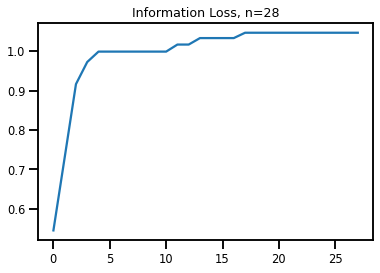

In [45]:
plt.plot(np.cumsum(np.array(info_loss)))
plt.title(f"Information Loss, n={train_state.n_layers}")

<Figure size 432x288 with 0 Axes>

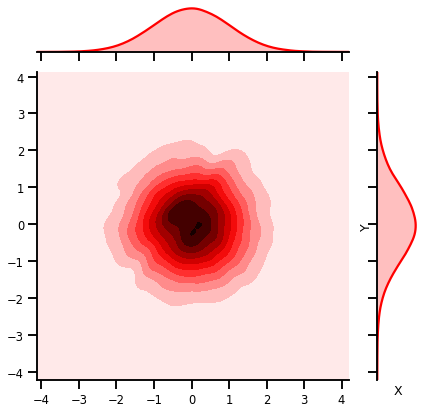

In [39]:
plot_joint(train_state.X)

### Invertible

In [47]:
import time
from typing import List


def rbig_inverse_transform(X: np.ndarray, params: List) -> np.ndarray:
#     init_val = X
    for iparam in reversed(params):
        X = inverse_func_jitted(iparam, X)
#         init_val = X
    return X

t0 = time.time()

data_approx = rbig_inverse_transform(train_state.X, train_state.params)
print(f"Time Taken: {(time.time() - t0):.4f}")

# check that the forward and inverse are close
chex.assert_tree_all_close(data, data_approx)

Time Taken: 0.6586


In [49]:
chex.assert_tree_all_close(data, data_approx, rtol=1e-7)

In this particular example, I was able to get it up to a maximum tolerance of 1e-9. This is pretty good.

In [50]:
%timeit _ = rbig_inverse_transform(train_state.X, train_state.params)

80.1 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<Figure size 432x288 with 0 Axes>

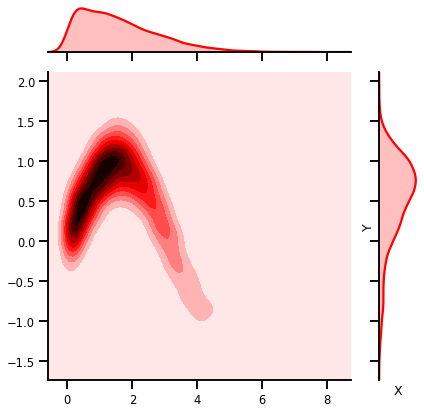

In [51]:
plot_joint(data_approx)

In [ ]:
t0 = time.time()
init_val = train_state.X
for iparam in reversed(train_state.params):
    X = inverse_func_jitted(iparam, init_val)
    init_val = X
print(f"Time Taken: {(time.time() - t0):.4f}")

### Forward Transformation

In [ ]:
data_new = 

In [59]:
import time
t0 = time.time()
init_val = data
for iparam in train_state.params:
    X, _ = forward_transform(iparam, init_val)
    init_val = X
print(f"Time Taken: {(time.time() - t0):.4f}")
    
t0 = time.time()
init_val = data
for iparam in train_state.params:
    X, _ = forward_func_jitted(iparam, init_val)
    init_val = X
print(f"Time Taken: {(time.time() - t0):.4f}")

Time Taken: 0.4648
Time Taken: 0.7312


<Figure size 432x288 with 0 Axes>

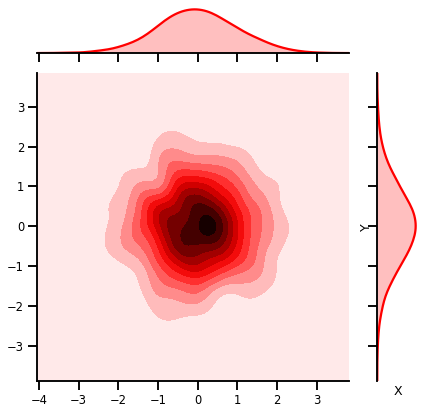

In [60]:
plot_joint(init_val)

#### Reverse Transformation

In [61]:
t0 = time.time()
init_val = train_state.X
for iparam in reversed(train_state.params):
    X = inverse_transform(iparam, init_val)
    init_val = X
print(f"Time Taken: {(time.time() - t0):.4f}")


t0 = time.time()
init_val = train_state.X
for iparam in reversed(train_state.params):
    X = inverse_func_jitted(iparam, init_val)
    init_val = X
print(f"Time Taken: {(time.time() - t0):.4f}")



Time Taken: 0.4054
Time Taken: 0.3998


<Figure size 432x288 with 0 Axes>

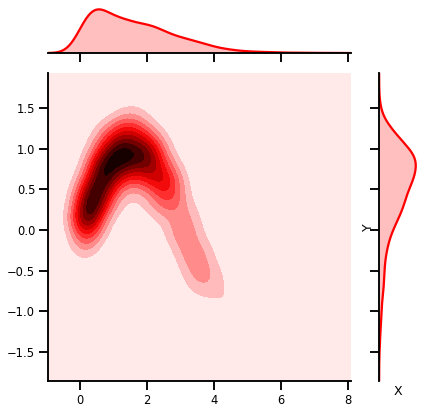

In [62]:
plot_joint(init_val)

In [63]:
train_state.n_layers

12